In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [2]:
# LSTM_Live 폴더의 모든 CSV 파일 병합
def LSTM_Live_Merge(folder_path):
    
    csv_files = []

    # 하위 폴더까지 탐색
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.endswith('.csv'):
                csv_path = os.path.join(root, file)
                
                # CSV 불러오기
                df = pd.read_csv(csv_path)
                csv_files.append(df)

    # 모든 CSV 파일 병합
    if csv_files:
        combined_df = pd.concat(csv_files, ignore_index=True)
        print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
        return combined_df
    else:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()


In [3]:
def natural_sort_key(s):
    return [int(text) if text.isdigit() else text.lower() for text in re.split(r'(\d+)', s)]

# 폴더 내 CSV 파일 병합
def LSTM_Capture_Merge(folder_path, sequence):
    
    csv_files = []

    for root, _, files in sorted(os.walk(folder_path), key=lambda x: natural_sort_key(x[0])):
        sorted_files = sorted([file for file in files if file.endswith('.csv')], key=natural_sort_key)
        file_count = len(sorted_files)
        
        if file_count == 0:
            continue  # CSV 파일이 없는 폴더는 건너뜀
        
        if file_count % sequence != 0:
            print(f"[제외] {root}: CSV 파일 수 {file_count}개는 {sequence}의 배수가 아닙니다.")
            continue  # sequence의 배수가 아니면 병합 제외

        for file in sorted_files:
            csv_path = os.path.join(root, file)
            csv_files.append(csv_path)

    if not csv_files:
        print("병합할 CSV 파일이 없습니다.")
        return pd.DataFrame()
    
    # CSV 파일 병합 (float_precision 추가)
    dataframes = [pd.read_csv(file, float_precision='round_trip') for file in csv_files]
    combined_df = pd.concat(dataframes, ignore_index=True)
    print(f"총 {len(csv_files)}개의 CSV 파일을 병합했습니다. 데이터 크기: {combined_df.shape}")
    return combined_df

In [4]:
# 데이터 시퀀스별로 변환
def reshape_to_sequences(data, labels, seq_length):
    sequences = []
    sequence_labels = []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data[i:i + seq_length])
        sequence_labels.append(labels[i + seq_length - 1])  # 시퀀스의 마지막 레이블 사용
    return np.array(sequences), np.array(sequence_labels)

In [5]:
# 클래스 균등하게 정리
def balance_classes(df, class_column, target_samples):

    # 그룹화하여 각 클래스에서 샘플링
    balanced_df = df.groupby(class_column).apply(
        lambda x: x.sample(n=target_samples, random_state=42) if len(x) >= target_samples else x
    )
    
    # 인덱스 초기화
    balanced_df = balanced_df.reset_index(drop=True)
    return balanced_df

In [8]:
# 데이터 불러오기 및 병합
folder_path = './Data'  # 데이터 폴더 경로
df_live = LSTM_Live_Merge(folder_path + '/LSTM_Live') # LSTM_Live 폴더 병합
df_capture = LSTM_Capture_Merge(folder_path + '/LSTM_Capture', sequence=3) # LSTM_Capture 폴더 병합
df= pd.concat([df_live, df_capture], ignore_index=True) # 전체 폴더 병합

병합할 CSV 파일이 없습니다.
총 4674개의 CSV 파일을 병합했습니다. 데이터 크기: (4674, 35)


In [9]:
# 정리 전 클래스별 갯수 확인
print(df['action_class'].value_counts())

action_class
2    1959
1    1362
0    1353
Name: count, dtype: int64


In [ ]:
# 클래스 균등하게 정리
df = balance_classes(df, class_column='action_class', target_samples=96)

C:\Users\Public\Documents\ESTsoft\CreatorTemp\ipykernel_15796\2504395227.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_df = df.groupby(class_column).apply(


In [10]:
# 데이터프레임 확인
print(df['action_class'].value_counts())
df

action_class
2    1959
1    1362
0    1353
Name: count, dtype: int64


,kp0_x,kp0_y,kp1_x,kp1_y,kp2_x,kp2_y,kp3_x,kp3_y,kp4_x,kp4_y,...,kp12_y,kp13_x,kp13_y,kp14_x,kp14_y,kp15_x,kp15_y,kp16_x,kp16_y,action_class
0,0.619108,0.153473,0.671352,0.132504,0.552828,0.129848,-2.204969,-0.222527,0.434993,0.137411,...,0.548048,0.689017,0.733447,0.377482,0.741448,0.638528,0.881347,0.326132,0.884203,0
1,0.646697,0.163598,0.708872,0.138540,0.562228,0.137520,0.788843,0.137759,0.419266,0.139350,...,0.556965,0.780411,0.747178,0.393982,0.758135,0.800466,0.894322,0.410815,0.893541,0
2,0.472753,0.160226,0.537387,0.134876,0.403421,0.136496,0.651228,0.134320,0.314455,0.136958,...,0.548825,0.657804,0.745717,0.310967,0.745665,0.593995,0.886244,0.339651,0.896255,0
3,0.477675,0.155960,0.550299,0.132962,0.417055,0.129028,0.664314,0.135434,0.329754,0.124835,...,0.555528,0.635761,0.766941,0.320649,0.761124,0.587906,0.895615,0.422887,0.898624,0
4,0.485582,0.152856,0.558880,0.130384,0.421838,0.128274,0.678876,0.137752,0.334627,0.130701,...,0.554923,0.644739,0.768907,0.312909,0.760498,0.601461,0.897247,0.421875,0.899406,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4669,0.587818,0.187804,0.662575,0.172892,0.564089,0.152314,0.788176,0.161725,-1.154639,-0.235294,...,0.455308,0.529604,0.697885,0.522542,0.580411,0.393116,0.861140,0.602422,0.741962,2
4670,0.811706,0.220952,0.856653,0.215300,0.808533,0.182615,0.903519,0.187876,0.761880,0.108996,...,0.440658,0.586922,0.742254,0.272392,0.627259,0.485270,0.885862,0.141560,0.799468,2
4671,0.816539,0.188145,0.863207,0.185062,0.816996,0.150374,0.898576,0.170328,0.773834,0.083931,...,0.426985,0.550309,0.738347,0.262129,0.646352,0.434548,0.909979,0.077227,0.858937,2
4672,0.436553,0.155960,0.514314,0.135759,0.437887,0.128296,0.732023,0.151393,-1.158824,-0.150617,...,0.549071,0.656974,0.767015,0.477603,0.679473,0.609097,0.883213,0.520258,0.748338,2


In [11]:
# X, y 분리
X = df.iloc[:, :-1].values # 키포인트
y = df.iloc[:, -1].values # 클래스

In [12]:
# 레이블 원-핫 인코딩
y = to_categorical(y)

In [13]:
# 데이터 시퀀스 길이 지정
seq_length = 3  # 시퀀스 길이

# 데이터를 시퀀스 형태로 변환
X_seq, y_seq = reshape_to_sequences(X, y, seq_length)

In [14]:
# 데이터 분할
X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, random_state=42)

In [15]:
# LSTM 모델 정의
model = Sequential([
    LSTM(128, input_shape=(seq_length, X_train.shape[2]), return_sequences=True),
    LSTM(64),
    Dense(32, activation="relu"),
    Dense(y_train.shape[1], activation="softmax")
    ])

c:\Users\User\anaconda3\envs\action_recognition\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
 # 모델 컴파일 및 학습
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])
es = EarlyStopping(monitor = 'val_loss', min_delta = 0, patience = 15, mode = 'auto', restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, batch_size=32, callbacks=es).history

Epoch 1/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.4772 - loss: 1.0197 - val_accuracy: 0.5765 - val_loss: 0.8973
Epoch 2/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6271 - loss: 0.8222 - val_accuracy: 0.6631 - val_loss: 0.7755
Epoch 3/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.6947 - loss: 0.7139 - val_accuracy: 0.6920 - val_loss: 0.7026
Epoch 4/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7052 - loss: 0.6645 - val_accuracy: 0.6930 - val_loss: 0.6799
Epoch 5/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7487 - loss: 0.5874 - val_accuracy: 0.7112 - val_loss: 0.6543
Epoch 6/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7669 - loss: 0.5603 - val_accuracy: 0.7380 - val_loss: 0.6490
Epoch 7/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.7865 - loss: 0.5146 - val_accuracy: 0.7551 - val_loss: 0.5771
Epoch 8/300
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8099 - loss: 0.4712 - val_acc

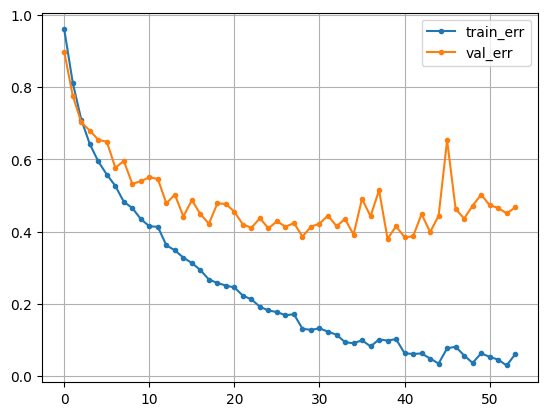

In [17]:
plt.plot(history['loss'], label = 'train_err', marker = '.')
plt.plot(history['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [18]:
# 모델 저장
output_model = './Model/LSTM.h5'
model.save(output_model)

In [19]:
# 학습된 모델 평가
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)
print(f"검증 데이터 정확도: {accuracy * 100:.2f}%")

검증 데이터 정확도: 87.91%
